In [562]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import itertools
import torch
import torch.nn.functional as F
import torch_sparse

from models.convs import SheafConv
from lib.laplace import build_norm_sheaf_laplacian, remove_duplicate_edges, build_sheaf_difussion_matrix, dirichlet_energy
from torch_geometric.nn.dense.linear import Linear
from scipy import linalg
from torch_geometric.utils import to_dense_adj, from_networkx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [50]:
class RandomSheafCN(torch.nn.Module):
    def __init__(self, N, K, edge_index, num_feat, num_classes):
        super().__init__()
        
        E = edge_index.size(1)
        maps = torch.DoubleTensor(size=(E, 1, K, K)).uniform_(-1.0, 1.0)
        maps = torch.cat((maps, maps), dim=1)

        # maps = torch.eye(K).view(1, 1, K, K).tile(E, 2, 1, 1)
        assert list(maps.size()) == [E, 2, K, K]
        P, L = build_sheaf_difussion_matrix(N, K, edge_index, maps, augmented=True, return_laplacian=True)
        print(K)
        
        self.N = N
        C = 16
        use_B = True
        self.conv1 = SheafConv(L, P, K, in_feat=num_feat, out_feat=C, use_B=use_B)
        self.conv2 = SheafConv(L, P, K, in_feat=C, out_feat=C, use_B=use_B)
        self.linear = Linear(K*C, num_classes)

    def forward(self, data):
        x = data.x

        x = self.conv1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x)
        # x = F.relu(x)
        
        x = x.view(self.N, -1)
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

In [51]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
N = data.x.size(0)
K = 4
C = data.x.size(1)
data.x = data.x.t().reshape(C, N, 1).tile(1, 1, K).reshape(C, N*K).t()

In [52]:
edge_index = remove_duplicate_edges(data.edge_index)
model = RandomSheafCN(N, K, edge_index, dataset.num_node_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

Removed 5278 edges
4


TypeError: reshape(): argument 'shape' must be tuple of ints, but found element of type Tensor at pos 1

In [57]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print('Test Accuracy: {:.4f}'.format(acc))
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print('Train Accuracy: {:.4f}'.format(acc))

Test Accuracy: 0.7560
Train Accuracy: 1.0000


## Oversmoothing

Generate an Erdos Renyi Graph

In [563]:
n=2
p=1.0
ER = nx.erdos_renyi_graph(n, p, seed=0)

In [572]:
N = n
K = 3

data = from_networkx(ER)
data.x = torch.DoubleTensor(size=(N*K,1)).normal_(0.0, 1.0)
print(data.x.size())

torch.Size([6, 1])


Generate a random sheaf

In [573]:
import scipy 
from scipy.stats import ortho_group

E = data.edge_index.size(1) // 2

maps = torch.DoubleTensor(size=(E, 2, K, K)).uniform_(-3.0, 3.0)

# maps=torch.empty(E, 1, K, K).to(dtype=torch.float64)
# for i in range(E):
    # maps[i, 0, :, :] = torch.tensor(ortho_group.rvs(K))
#     maps[i, 1, :, :] = torch.tensor(ortho_group.rvs(K))
# maps = torch.cat((maps, maps), dim=1)

edge_index = remove_duplicate_edges(data.edge_index)
P, L = build_sheaf_difussion_matrix(N, K, edge_index, maps, augmented=True, return_laplacian=True)

Removed 1 edges


In [574]:
Ld = torch.sparse_coo_tensor(L[0], L[1], (N*K, N*K)).to_dense()

assert torch.max(torch.abs(Ld - Ld.t()) < 1e-10)
                 
eigenvals = torch.linalg.eigvalsh(Ld)
assert torch.all(eigenvals > -1e-12)
assert torch.all(torch.linalg.eigvalsh(Ld) < (2.0 + 1e-13))

print(eigenvals[:10])

gap = eigenvals[eigenvals > 1e-10][0].item()
print("Gap", gap)

tensor([-5.6099e-16, -2.1652e-16,  3.8739e-16,  1.2457e+00,  1.6153e+00,
         1.8735e+00])
Gap 1.2457260018903262


Write a model made especially for this experiment

In [555]:
class RandomDeepSheafCN(torch.nn.Module):
    def __init__(self, P, N, K, edge_index, num_feat, num_classes=2, layers=20):
        super().__init__()        
        
        self.N = N
        self.layers = layers
        self.convs = torch.nn.ModuleList()
        
        for i in range(layers):
            conv = SheafConv(P, N, K, in_feat=1, out_feat=1)
            torch.nn.init.uniform_(conv.B.weight, a=-1.0, b=1.0)
            self.convs.append(conv)

    def forward(self, data):
        x = data.x
        out = [x.detach().clone()]
        
        for i in range(self.layers):
            x = self.convs[i](x)
            # x = F.relu(x)
            # x = F.leaky_relu(x, negative_slope=0.4)
            # x = torch.tanh(x)
            x = F.hardtanh(x)
            # x = torch.sigmoid(x)
            out.append(x.detach().clone())
        
        return out

In [556]:
layers = 12
model = RandomDeepSheafCN(P, N, K, edge_index, 1, layers=layers).to(device)

op_norms = []
for i in range(layers):
    W = model.convs[i].B.weight.data.detach().clone()
    _, s, _ = torch.linalg.svd(W)
    op_norms.append(s[0].item())
    
print("Operator norms")
print(op_norms)

print("Max bound")
print(np.max(op_norms)**2 * (1 - gap)**2)
print("Min bound")
print(np.min(op_norms)**2 * (1 - gap)**2)

Operator norms
[1.5621342994713536, 2.056814233273969, 1.4534800394650471, 1.757426990413283, 1.5116272737211924, 1.8802861370301078, 1.440144394021379, 1.9139292005954416, 1.2873876649302363, 2.0390778883139307, 1.761151252411225, 2.0251625824673214]
Max bound
0.1806837978527781
Min bound
0.07078606325595849


In [557]:
out = model(data)

In [558]:
energies = []
for i in range(len(out)):
    energies.append(dirichlet_energy(L, out[i], size=N*K))

energy_bounds = [energies[0]]
# Compute the upper bound on the energies
for i in range(len(out) - 1):
    energy_bounds.append(energy_bounds[-1] * (1 - gap)**2 * op_norms[i]**2)

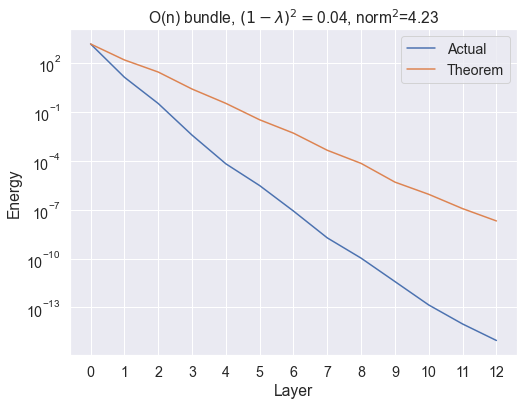

[1560.114102196318, 14.067819970286177, 0.34270182498629936, 0.0038978733005591137, 6.745760403421821e-05, 3.086521658754636e-06, 8.40554335319438e-08, 1.887249098018587e-09, 1.0722867442572457e-10, 3.914021841455281e-12, 1.422793943231925e-13, 9.688875522114653e-15, 9.39161734830792e-16]


In [559]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)  

plt.figure(figsize=(8, 6))
plt.plot(np.arange(layers+1), energies, label='Actual')
plt.plot(np.arange(layers+1), energy_bounds, label='Theorem')
plt.yscale("log")
plt.legend()
plt.title(fr"O(n) bundle, $(1-\lambda)^2=${(1-gap)**2:.2f}, norm$^2$={np.max(op_norms)**2:.2f}")
plt.xticks(np.arange(layers+1))
plt.xlabel('Layer')
plt.ylabel('Energy')
plt.show()
print(energies)

In [ ]:
norms = []
for i in range(len(out)):
    norms.append(torch.norm(out[i]).item())
print(norms)

[39.77319791068085, 3.8759898269762387, 0.9690051277016571, 0.5624032288510933, 0.43366914052910477, 0.4735118004766499, 0.4944678638174604, 0.3110128348690607, 0.38275324458262877, 0.41433380589868707, 0.4989268811911325, 0.7897006852634002, 0.9346779584193938]


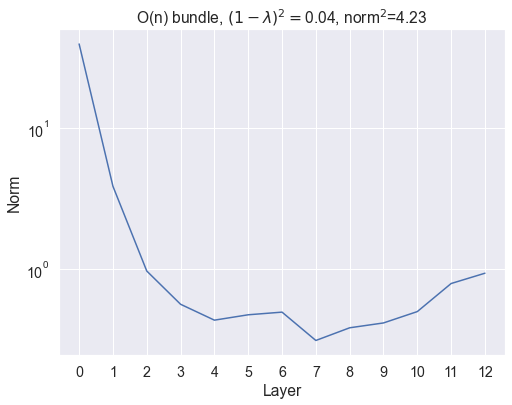

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(layers+1), norms)
plt.xticks(np.arange(layers+1))
plt.title(fr"O(n) bundle, $(1-\lambda)^2=${(1-gap)**2:.2f}, norm$^2$={np.max(op_norms)**2:.2f}")
plt.yscale("log")
plt.xlabel('Layer')
plt.ylabel('Norm')
plt.show()